# Import Packages & Data

In [2]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import random

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import cohen_kappa_score

from skll.metrics import kappa

from customUtils import limits

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100
plt.style.use('ggplot')

np.warnings.filterwarnings('ignore') 

C:\Users\David\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
C:\Users\David\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\David\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (

In [223]:
# Import Pre-processed Data
training_set = pd.read_pickle('preprocessedSupervised.pkl')

# Select features
predictors = [  
    # 'essay_id',
    # 'topic',
    # 'essay',
    # 'target_score',
    # 'rater1_domain1',
    # 'rater2_domain1',
    'subjectivity',
    'polarity',
    # 'matches',
    'corrections',
    # 'corrected',
    # 'tokens',
    # 'lemma',
    # 'pos',
    # 'sents',
    'ner',
    'word_count',
    'char_count',
    'token_count',
    'unique_token_count',
    'nostop_count',
    'sent_count',
    'ner_unredacted_count',
    'comma',
    'question',
    'exclamation',
    'quotation',
    'organization',
    'caps',
    'person',
    'location',
    'money',
    'time',
    'date',
    'percent',
    'noun',
    'adj',
    'pron',
    'verb',
    'cconj',
    'adv',
    'det',
    'propn',
    'num',
    'part',
    'intj',
    'flesch',
    'smog',
    'kincaid',
    'coleman_liau',
    'readability',
    'dale_chall',
    'difficult_words',
    'linsear',
    'gunning_fog',
    # 'grade_level',
    'wc_ratio',
    'sw_ratio',
    'ners_ratio',
    'TTR',
    'dw_ratio',
    'h_similarity',
    'm_similarity',
    # 'l_essay',
]

# Regression Pipeline

In [224]:
def evaluate(df, topic, features, model):
    """Regression pipeline with kappa evaluation"""
    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    pipeline = Pipeline(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [225]:
# Supervised Pipeline k Fold
k = 5

models = [
    [('s_SVM', StandardScaler()),('linearSVC', LinearSVC(C=0.01))],
    [('s_LinearReg', StandardScaler()),('lm', LinearRegression())], 
    [('s_ForestEnsemble', RandomForestRegressor(n_estimators=20))],  
    [('s_ElasticNet', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000))],
    [('s_kNN', BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5))]
]

for steps in models:
    results = open("models/%s_Results.txt" % steps[0][0], "w+")
    print('Model: %s' % steps[0][0])
    for topic in range(1,9):
        for fold in range(0,k):
            score = evaluate(training_set, topic, predictors, steps)
            results.write("%s \n" % score)
        results.write("\n ---- \n")
    results.close()

Model: s_SVM
Model: s_LinearReg
Model: s_ForestEnsemble
Model: s_ElasticNet
Model: s_kNN


In [68]:
# Ensemble Method (doesn't work with the Pipeline Method)
kappas = []
weights = []

def voting(df, topic, features, model):
    """Regression pipeline; Returns QWK Score"""
    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=26)
    model.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return kappa(y_pred, y_test, weights='quadratic')

eclf = VotingClassifier(estimators=models)
for topic in range(1,9):
    kappas.append(voting(training_set, topic, predictors, eclf))
    weights.append(len(training_set[training_set.topic==topic]))
    
# mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Model: %s' % steps[0][0])
i=1
for k in kappas:
    print('Prompt: {:.4f} | QWK: {:,.2f}'.format(i, k))
    i = i+1
print('Weighted Mean: {:.4f}'.format(mqwk))

ValueError: not enough values to unpack (expected 2, got 1)

In [81]:
# Quick Pipeline for GridSearchCV
def en_evaluate(df, topic, features):
    paramgrid = {'l1_ratio': [.01, .1, .3, .5, .7, .99], 'alpha': [0.001, 0.01, 0.1, 1]}
    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),
                      param_grid=paramgrid,
                      cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [ ]:
for topic in range(1,9):
    kappas.append(en_evaluate(training_set, topic, predictors))
print('Imrpoved ElasticNet QWK Scores:')
kapppas

Topic 1 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}


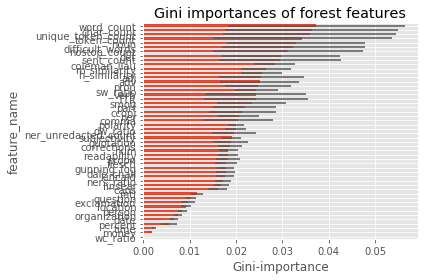

In [10]:
# Random Forest Gini-Importance of Features
X = training_set[predictors]
y = training_set['target_score'].astype(np.float64)

forest = ExtraTreesClassifier(n_estimators=250, random_state=26)
forest.fit(X, y)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# plot feature importances
features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance')\
        .plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.tight_layout()
plt.show()

In [179]:
# Limits the features to k-top features and measures improvement on linear regression 
k = 10
top_features = features.sort_values('importance', ascending=False)['feature_name'].tolist()[:k]
all_features = features.sort_values('importance', ascending=False)['feature_name'].tolist()

score_new = []
score_old = []

for topic in range(1,9):
    score_new = []
    score_old = []
    for fold in range(1,51):
        steps = [('scaler', StandardScaler()),('lm', LinearRegression())]
        steps2 = [('scaler', StandardScaler()),('lm', LinearRegression())]
        score_new.append(evaluate(training_set, topic, top_features, steps))
        score_old.append(evaluate(training_set, topic, all_features, steps2))
    print('Prompt: {:.0f} | Improvement: {:,.3f}'.format(topic, (sum(score_new) - sum(score_old))/(len(score_new) + len(score_old))))

Prompt: 1 | Improvement: -0.239
Prompt: 2 | Improvement: -0.164
Prompt: 3 | Improvement: -0.328
Prompt: 4 | Improvement: -0.303
Prompt: 5 | Improvement: -0.368
Prompt: 6 | Improvement: -0.349
Prompt: 7 | Improvement: -0.242
Prompt: 8 | Improvement: -0.309
